In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.interpolate as interp

# for plots
plt.rcParams.update({"text.usetex": True, 'font.size': 14})
colors = plt. rcParams['axes.prop_cycle'].by_key()['color']

# ensure the notebook generate the same randomess
np.random.seed(1337)

In [2]:
N = 5
R = 100_000

v = np.random.uniform(0,1,(N,R))

# BNE in first-price sealed bid

b_star = lambda vi,N :((N-1)/N) * vi
b = b_star(v,N)

In [5]:
idx = np.argsort(v, axis=0)  # Biders' values are sorted in ascending order in each auction. 
# We record the order because we want to apply it to bid price and their id.

v = np.take_along_axis(v, idx, axis=0)  # same as np.sort(v, axis=0), except now we retain the idx
b = np.take_along_axis(b, idx, axis=0)

ii = np.repeat(np.arange(1,N+1)[:,None], R, axis=1)  # the id for the bidders is created.
ii = np.take_along_axis(ii, idx, axis=0)  # the id is sorted according to bid price as well.

winning_player = ii[-1,:] # In FPSB and SPSB, winners are those with highest values.

winner_pays_fpsb = b[-1,:]  # highest bid
winner_pays_spsb = v[-2,:]  # 2nd-highest valuation

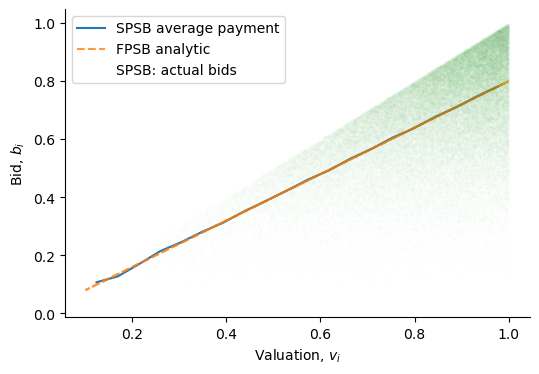

In [7]:
# We intend to compute average payments of different groups of bidders 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
binned = stats.binned_statistic(v[-1,:], v[-2,:], statistic='mean', bins=20)
xx = binned.bin_edges
xx = [(xx[ii]+xx[ii+1])/2 for ii in range(len(xx)-1)]
yy = binned.statistic

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(xx, yy, label='SPSB average payment')
ax.plot(v[-1,:], b[-1,:], '--', alpha = 0.8, label = 'FPSB analytic')
ax.plot(v[-1,:], v[-2,:], 'o', alpha = 0.05, markersize = 0.1, label = 'SPSB: actual bids')

ax.legend(loc='best')
ax.set_xlabel('Valuation, $v_i$')
ax.set_ylabel('Bid, $b_i$')
sns.despine()

The average payment of FPSB: 0.6665. Std.: 0.1129. Median: 0.6967
The average payment of SPSB: 0.6667. Std.: 0.1782. Median: 0.6862


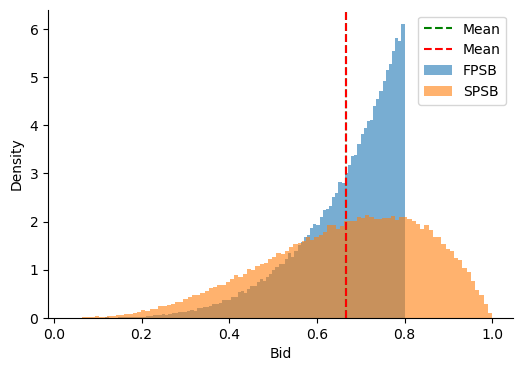

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

for payment,label in zip([winner_pays_fpsb, winner_pays_spsb], ['FPSB', 'SPSB']):
    print('The average payment of %s: %.4f. Std.: %.4f. Median: %.4f'% (label,payment.mean(),payment.std(),np.median(payment)))
    ax.hist(payment, density=True, alpha=0.6, label=label, bins=100)

ax.axvline(winner_pays_fpsb.mean(), ls='--', c='g', label='Mean')
ax.axvline(winner_pays_spsb.mean(), ls='--', c='r', label='Mean')    

ax.legend(loc='best')
ax.set_xlabel('Bid')
ax.set_ylabel('Density')
sns.despine()

In [9]:
def evaluate_largest(v_hat, array, order=1):
    """
    A method to estimate the largest (or certain-order largest) value of the other biders,
    conditional on player 1 wins the auction. 

    Parameters:
    ----------
    v_hat : float, the value of player 1. The biggest value in the auction that player 1 wins.

    array: 2 dimensional array of bidders' values in shape of (N,R), 
           where N: number of players, R: number of auctions

    order: int. The order of largest number among bidders who lose.
                e.g. the order for largest number beside winner is 1. 
                     the order for second-largest number beside winner is 2. 

    """
    N,R = array.shape
    array_residual=array[1:,:].copy()  # drop the first row because we assume first row is the winner's bid
    
    index=(array_residual<v_hat).all(axis=0)
    array_conditional=array_residual[:,index].copy()
    
    array_conditional=np.sort(array_conditional, axis=0)
    return array_conditional[-order,:].mean()

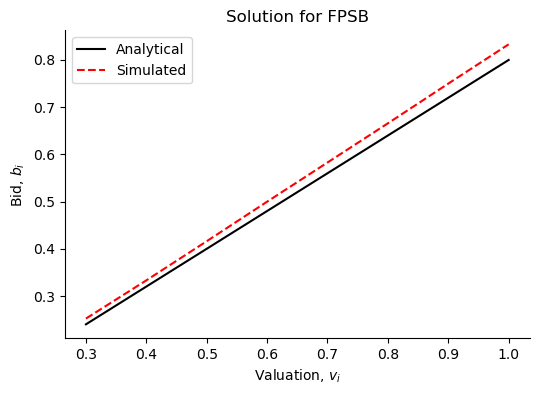

In [10]:
v_grid = np.linspace(0.3,1,8)
bid_analytical = b_star(v_grid,N)
bid_simulated = [evaluate_largest(ii, v) for ii in v_grid]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(v_grid, bid_analytical, '-', color='k', label='Analytical')
ax.plot(v_grid, bid_simulated, '--', color='r', label='Simulated')

ax.legend(loc='best')
ax.set_xlabel('Valuation, $v_i$')
ax.set_ylabel('Bid, $b_i$')
ax.set_title('Solution for FPSB')
sns.despine()

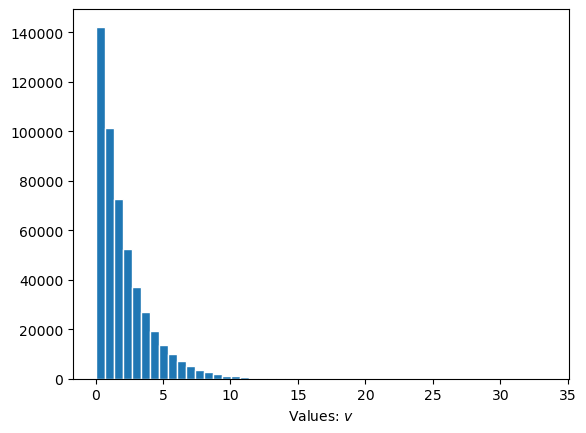

In [11]:
np.random.seed(1337)
v = np.random.chisquare(df=2, size=(N*R,))

plt.hist(v, bins=50, edgecolor='w')
plt.xlabel('Values: $v$')
plt.show()

In [12]:
np.random.seed(1337)
v = np.random.chisquare(df=2, size=(N,R))


# we compute the quantile of v as our grid
pct_quantile = np.linspace(0, 100, 101)[1:-1]
v_grid = np.percentile(v.flatten(), q=pct_quantile)

EV=[evaluate_largest(ii, v) for ii in v_grid]  
# nan values are returned for some low quantiles due to lack of observations 

C:\Users\BRIANL~1\AppData\Local\Temp/ipykernel_13396/1297414400.py:25: RuntimeWarning: Mean of empty slice.
  return array_conditional[-order,:].mean()
C:\Users\Brian Lee\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
# we insert 0 into our grid and bid price function as a complement
EV=np.insert(EV,0,0)
v_grid=np.insert(v_grid,0,0)

b_star_num = interp.interp1d(v_grid, EV, fill_value="extrapolate")

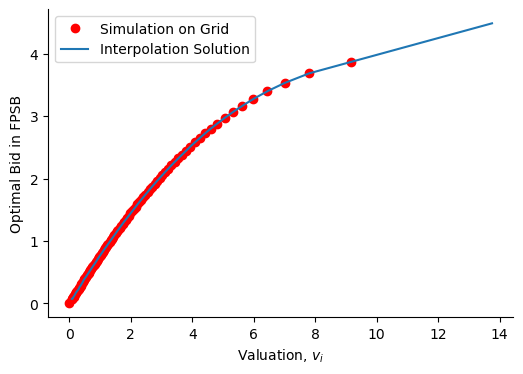

In [14]:
pct_quantile_fine = np.linspace(0, 100, 1001)[1:-1]
v_grid_fine = np.percentile(v.flatten(), q=pct_quantile_fine)

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(v_grid, EV, 'or', label='Simulation on Grid')
ax.plot(v_grid_fine, b_star_num(v_grid_fine) , '-', label='Interpolation Solution')

ax.legend(loc='best')
ax.set_xlabel('Valuation, $v_i$')
ax.set_ylabel('Optimal Bid in FPSB')
sns.despine()

In [15]:
b=b_star_num(v)

idx = np.argsort(v, axis=0)
v = np.take_along_axis(v, idx, axis=0)  # same as np.sort(v, axis=0), except now we retain the idx
b = np.take_along_axis(b, idx, axis=0)

ii = np.repeat(np.arange(1,N+1)[:,None], R, axis=1)
ii = np.take_along_axis(ii, idx, axis=0)

winning_player = ii[-1,:]

winner_pays_fpsb = b[-1,:]  # highest bid
winner_pays_spsb = v[-2,:]  # 2nd-highest valuation

The average payment of FPSB: 2.5693. Std.: 0.8383. Median: 2.5829
The average payment of SPSB: 2.5661. Std.: 1.3580. Median: 2.3180


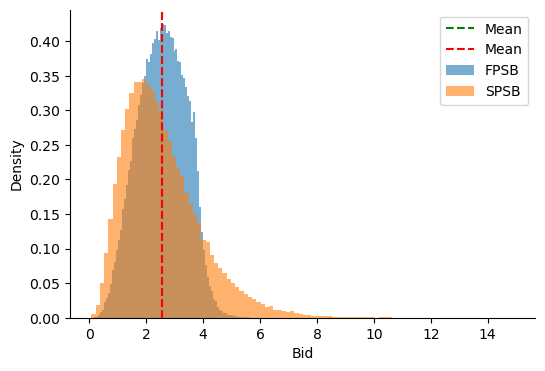

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

for payment,label in zip([winner_pays_fpsb, winner_pays_spsb], ['FPSB', 'SPSB']):
    print('The average payment of %s: %.4f. Std.: %.4f. Median: %.4f'% (label,payment.mean(),payment.std(),np.median(payment)))
    ax.hist(payment, density=True, alpha=0.6, label=label, bins=100)

ax.axvline(winner_pays_fpsb.mean(), ls='--', c='g', label='Mean')
ax.axvline(winner_pays_spsb.mean(), ls='--', c='r', label='Mean')

ax.legend(loc='best')
ax.set_xlabel('Bid')
ax.set_ylabel('Density')
sns.despine()

In [17]:
class bid_price_solution:
    
    def __init__(self, array):
        """
        A class that can plot the value distribution of bidders, 
        compute the optimal bid price for bidders in FPSB
        and plot the distribution of winner's payment in both FPSB and SPSB

        Parameters:
        ----------

        array: 2 dimensional array of bidders' values in shape of (N,R), 
               where N: number of players, R: number of auctions

        """
        self.value_mat=array.copy()
        
        return None
    
    def plot_value_distribution(self):
        plt.hist(self.value_mat.flatten(), bins=50, edgecolor='w')
        plt.xlabel('Values: $v$')
        plt.show()
        
        return None
    
    def evaluate_largest(self, v_hat, order=1):
        N,R = self.value_mat.shape
        array_residual = self.value_mat[1:,:].copy()  
        # drop the first row because we assume first row is the winner's bid

        index=(array_residual<v_hat).all(axis=0)
        array_conditional=array_residual[:,index].copy()

        array_conditional=np.sort(array_conditional, axis=0)
        
        return array_conditional[-order,:].mean()
    
    def compute_optimal_bid_FPSB(self):
        # we compute the quantile of v as our grid
        pct_quantile = np.linspace(0, 100, 101)[1:-1]
        v_grid = np.percentile(self.value_mat.flatten(), q=pct_quantile)

        EV=[self.evaluate_largest(ii) for ii in v_grid]  
        # nan values are returned for some low quantiles due to lack of observations 
        
        # we insert 0 into our grid and bid price function as a complement
        EV=np.insert(EV,0,0)
        v_grid=np.insert(v_grid,0,0)

        self.b_star_num = interp.interp1d(v_grid, EV, fill_value="extrapolate")
        
        pct_quantile_fine = np.linspace(0, 100, 1001)[1:-1]
        v_grid_fine = np.percentile(self.value_mat.flatten(), q=pct_quantile_fine)

        fig, ax = plt.subplots(figsize=(6, 4))

        ax.plot(v_grid, EV, 'or', label='Simulation on Grid')
        ax.plot(v_grid_fine, self.b_star_num(v_grid_fine) , '-', label='Interpolation Solution')

        ax.legend(loc='best')
        ax.set_xlabel('Valuation, $v_i$')
        ax.set_ylabel('Optimal Bid in FPSB')
        sns.despine()
        
        return None
    
    def plot_winner_payment_distribution(self):
        self.b = self.b_star_num(self.value_mat)
        
        idx = np.argsort(self.value_mat, axis=0)
        self.v = np.take_along_axis(self.value_mat, idx, axis=0)  # same as np.sort(v, axis=0), except now we retain the idx
        self.b = np.take_along_axis(self.b, idx, axis=0)

        self.ii = np.repeat(np.arange(1,N+1)[:,None], R, axis=1)
        self.ii = np.take_along_axis(self.ii, idx, axis=0)

        winning_player = self.ii[-1,:]

        winner_pays_fpsb = self.b[-1,:]  # highest bid
        winner_pays_spsb = self.v[-2,:]  # 2nd-highest valuation
        
        fig, ax = plt.subplots(figsize=(6, 4))

        for payment,label in zip([winner_pays_fpsb, winner_pays_spsb], ['FPSB', 'SPSB']):
            print('The average payment of %s: %.4f. Std.: %.4f. Median: %.4f'% (label,payment.mean(),payment.std(),np.median(payment)))
            ax.hist(payment, density=True, alpha=0.6, label=label, bins=100)

        ax.axvline(winner_pays_fpsb.mean(), ls='--', c='g', label='Mean')
        ax.axvline(winner_pays_spsb.mean(), ls='--', c='r', label='Mean')

        ax.legend(loc='best')
        ax.set_xlabel('Bid')
        ax.set_ylabel('Density')
        sns.despine()
        
        return None

In [18]:
np.random.seed(1337)
v = np.random.chisquare(df=2, size=(N,R))

chi_squ_case = bid_price_solution(v)

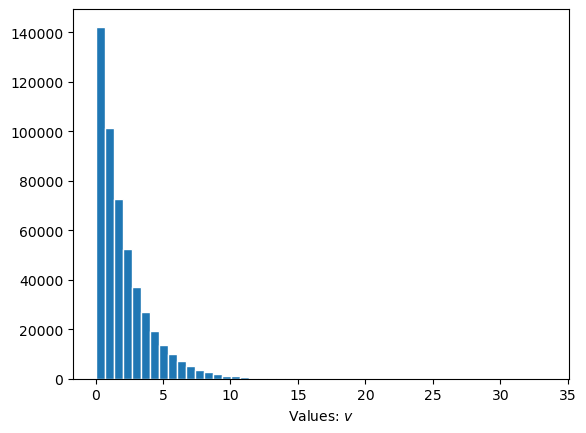

In [19]:
chi_squ_case.plot_value_distribution()

C:\Users\BRIANL~1\AppData\Local\Temp/ipykernel_13396/2108492276.py:37: RuntimeWarning: Mean of empty slice.
  return array_conditional[-order,:].mean()
C:\Users\Brian Lee\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


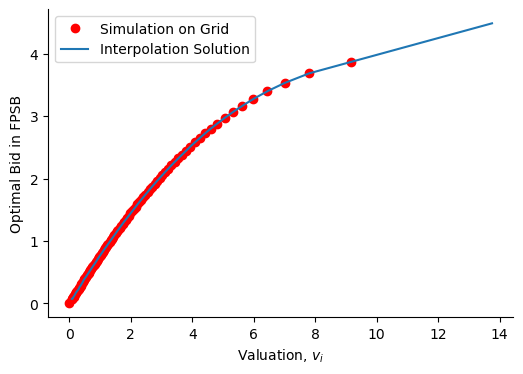

In [20]:
chi_squ_case.compute_optimal_bid_FPSB()

The average payment of FPSB: 2.5693. Std.: 0.8383. Median: 2.5829
The average payment of SPSB: 2.5661. Std.: 1.3580. Median: 2.3180


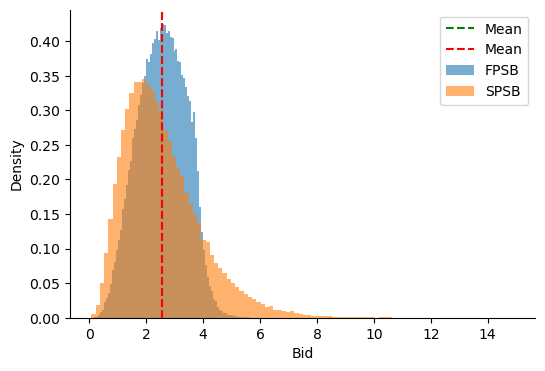

In [21]:
chi_squ_case.plot_winner_payment_distribution()